## Семинар 2 "Распознавание рукописных цифр"

ФИО: Шевченко Олег Владимирович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [13]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
import sys
%matplotlib inline

In [2]:
import torch
torch.cuda.is_available()

False

In [9]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Lambda(lambda x : x + 0.1 * torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

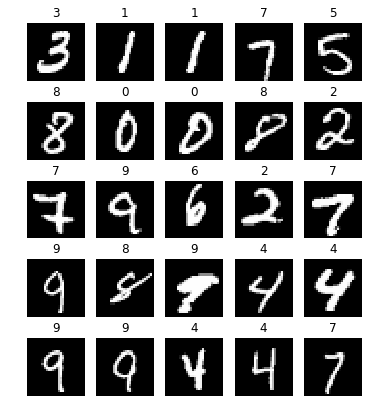

In [11]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [14]:
def train(network, epochs, learning_rate, loss=NLLLoss(), plot=True):
    train_loss_epochs = []
    test_loss_epochs = []
    # train_accuracy_epochs = []
    test_accuracy_epochs = []
    return_loss = []
    try:
        for epoch in range(epochs):
            losses = []
            # accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                # accuracies.append((np.argmax(prediction, 1)==y).mean())
            return_loss += losses
            train_loss_epochs.append(np.mean(losses))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            # test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
    return return_loss, train_loss_epochs, test_loss_epochs, test_accuracy_epochs

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

Epoch 19... (Train/Test) Loss: 0.288/0.284

/home/oleg/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


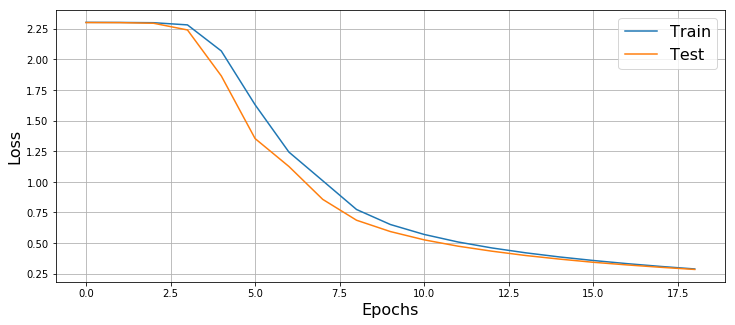

Точность классификации: 0.9259185303514377


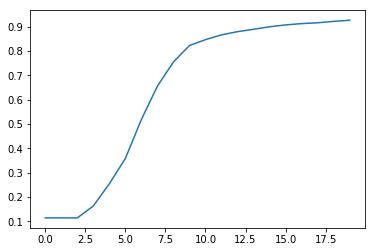

In [15]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

losses, _, ts_l_sig, acc = train(network, 20, 0.01, loss)
plt.plot(acc)
print("Точность классификации:", acc[-1])

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [5]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [6]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) Loss: 0.040/0.083

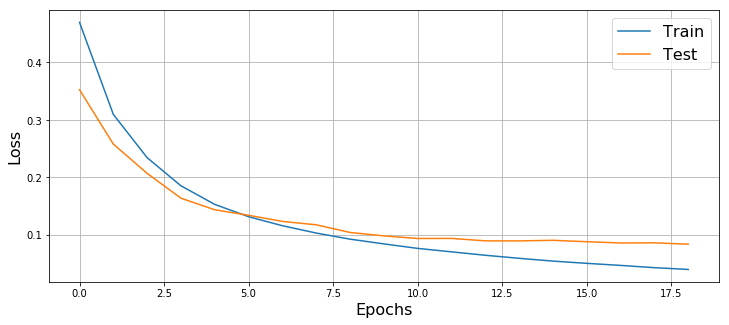

In [16]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
relu_loss,_,ts_l_relu,_ = train(network, 20, 0.01, loss)

Epoch 19... (Train/Test) Loss: 0.045/0.080

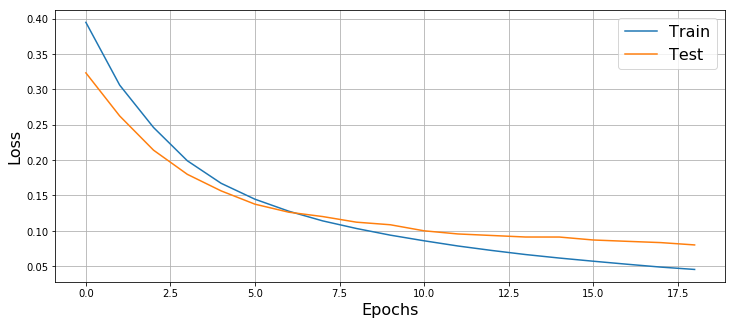

In [17]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
elu_loss,_,ts_l_elu,_ = train(network, 20, 0.01, loss)

Epoch 19... (Train/Test) Loss: 0.031/0.083

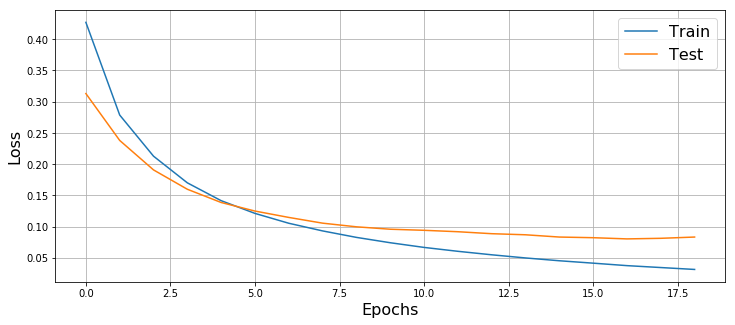

In [18]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
Tanh_loss,_,ts_l_tanh,_ = train(network, 20, 0.01, loss)

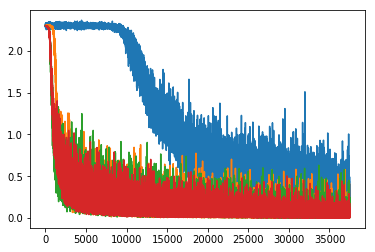

In [19]:
plt.plot(losses)
plt.plot(relu_loss)
plt.plot(elu_loss)
plt.plot(Tanh_loss)
plt.show()

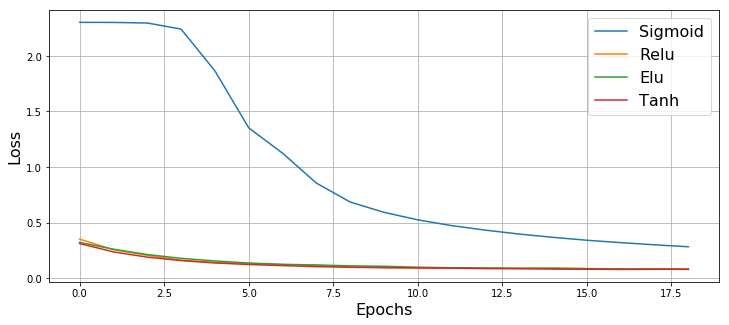

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(ts_l_sig[1:], label='Sigmoid')
plt.plot(ts_l_relu[1:], label='Relu')
plt.plot(ts_l_elu[1:], label='Elu')
plt.plot(ts_l_tanh[1:], label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()


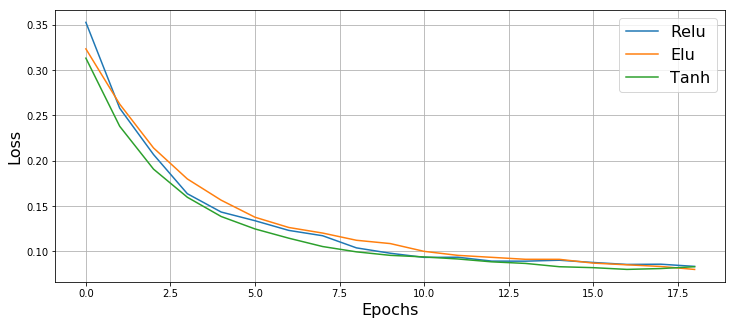

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(ts_l_relu[1:], label='Relu')
plt.plot(ts_l_elu[1:], label='Elu')
plt.plot(ts_l_tanh[1:], label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [34]:
errors = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = network.forward(X)
    
    for x_i, y_i in zip(X, y):
        l = loss.forward(x_i.reshape(1, -1), y_i.reshape(1, -1))
        errors.append((l, x_i.reshape(28, 28)))
    
    if len(errors) > 1000:
        break


In [39]:
errors.sort(key=lambda x: x[0], reverse=False)

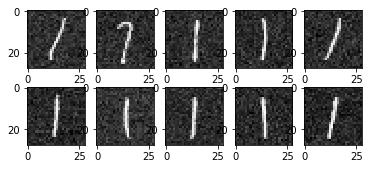

In [40]:
for i in range(10):
    plt.subplot(3, 5, i+1)
    img = np.copy(errors[i][1])
    img += np.random.randn(28*28).reshape(28, 28)*0.2
    plt.imshow(img, cmap=plt.cm.Greys_r)
#print(errors[1000][0])

### HW1 (1 балл): Реализовать Tanh

In [7]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        exp_X = np.exp(2 * X)
        return (exp_X - 1) / (exp_X + 1)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 4. / (np.exp(X) + np.exp(-X))**2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [8]:
def check_gradient(func, X, gradient):
    eps = 10**(-5)
    f_grad = np.zeros(gradient.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps            
            f_r = func(X)
            X[i, j] -= 2*eps            
            f_l = func(X)            
            X[i, j] += eps
                    
            f_grad[i, j] = (f_r - f_l) / 2 / eps
    return np.max(np.abs(gradient - f_grad))

In [60]:
np.random.seed(777)
X = np.ones((5, 10))
Y = np.ones((5, 10))
s = Tanh()
def loss(X):    
    res = s.forward(X)
    
    return np.sum(res)
s.forward(X)
res = s.backward(Y)
check_gradient(loss, X, res)

8.839540210914265e-11

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [21]:
def data_transformation(transformation):
    train_dataset_transform = MNIST('.', train=True, download=True, transform=transformation)
    test_dataset_transform = MNIST('.', train=False, transform=transformation)
    
    transform_old = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
    train_dataset_old = MNIST('.', train=True, download=True, transform=transform_old)
    test_dataset_old = MNIST('.', train=False, transform=transform_old)
    
    train_loader = DataLoader(train_dataset_old+train_dataset_transform, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset_old+test_dataset_transform, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

### Вращения (-15, 15)

In [27]:
rotation = transforms.RandomRotation(15)
transform_new = transforms.Compose([
                   rotation,
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
train_loader, test_loader = data_transformation(transform_new)

network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

losses_rotation, tr_l_rot, ts_l_rot, acc_rot = train(network, 20, 0.01, loss, False)

Epoch 19... (Train/Test) Loss: 0.033/0.074

### Случайны сдвиги

In [28]:
shift = transforms.RandomAffine(0, (0.1, 0.1))
transform_new = transforms.Compose([
                   shift,
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
train_loader, test_loader = data_transformation(transform_new)

network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

losses_shift, tr_l_sh, ts_l_sh, acc_sh = train(network, 20, 0.01, loss, False)

Epoch 19... (Train/Test) Loss: 0.064/0.075

### Шум

In [29]:
noise = transforms.Lambda(lambda x : x +  0.1 * torch.randn_like(x))
transform_new = transforms.Compose([
                   transforms.ToTensor(),
                   noise,
                   transforms.Normalize((0.1307,), (0.3081,))
                ])
train_loader, test_loader = data_transformation(transform_new)

network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

losses_noise, tr_l_no, ts_l_no, acc_no = train(network, 20, 0.01, loss, False)

Epoch 19... (Train/Test) Loss: 0.013/0.086

### Все аугментации вместе

In [30]:
transform_new = transforms.Compose([
    transforms.RandomAffine(15, (0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x +  0.1 * torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_loader, test_loader = data_transformation(transform_new)

network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

losses_all, tr_l_all, ts_l_all, acc_all = train(network, 20, 0.01, loss, False)


Epoch 19... (Train/Test) Loss: 0.060/0.072

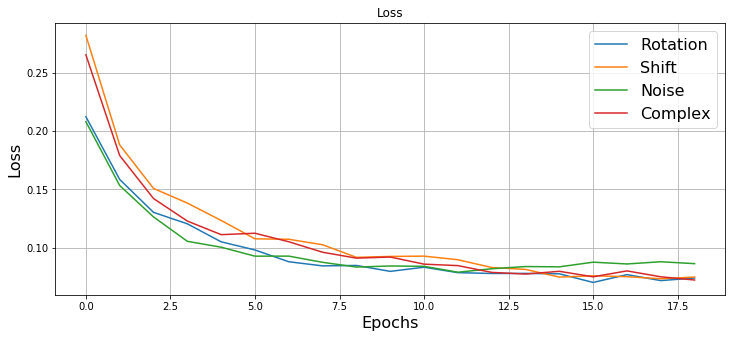

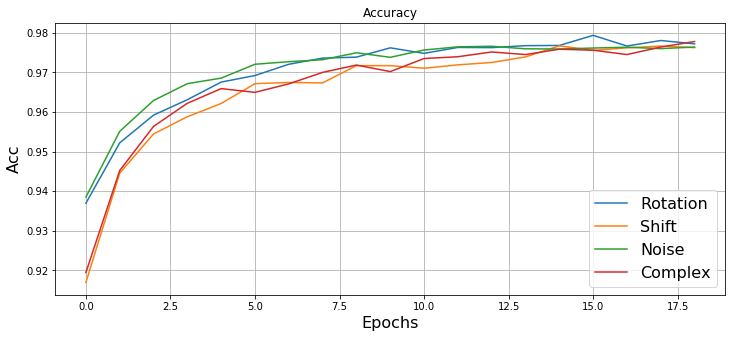

In [33]:
plt.figure(figsize=(12, 5))
plt.title('Loss')
plt.plot(ts_l_rot[1:], label='Rotation')
plt.plot(ts_l_sh[1:], label='Shift')
plt.plot(ts_l_no[1:], label='Noise')
plt.plot(ts_l_all[1:], label='Complex')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

plt.figure(figsize=(12, 5))
plt.title('Accuracy')
plt.plot(acc_rot[1:], label='Rotation')
plt.plot(acc_sh[1:], label='Shift')
plt.plot(acc_no[1:], label='Noise')
plt.plot(acc_all[1:], label='Complex')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acc', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

#### Выбор нелинейности:
    1) Сигмоида значительно хуже и медленнее сходится, чем другие функции активации
    2) Разница между relu, elu и tanh не такая значительная(tanh совсем немного выигрывает, но можно считать за погрешность), можно использовать любую из этих функций.
#### Предобработка данных:
    1) Любая предобработка данных хорошо влияет на сходимость
    2) Меньше всего прироста на тестовых данных дает добавление шума
    3) При совмещение всех методов аугментации заметен прирост скорости сходимости, но он все равно не очень большой.
    
Таким образом, выбор нелинейности и предобработка данных серьёзно влияют на скорость сходимости и итоговую точность модели